# Описание задачи

Многие знакомы с концепцией онлайн-рынков, где предлагаются бывшие в употреблении товары, включая возможность доступного приобретения качественных и полезных предметов. Однако всегда возникает вопрос: как устанавливаются цены на эти товары и какие факторы оказывают наибольшее воздействие на итоговую стоимость продажи? Этот вопрос особенно актуален, если речь идет о дорогих товарах, таких как автомобили.<br>

В данном проекте мы работаем с данными о продажах автомобилей на вторичном рынке. Целью вашего проекта является разработка модели для предсказания стоимости автомобилей на вторичном рынке.

- Date: Год выпуска автомобиля.<br>
- Make: Марка автомобиля.<br>
- Model: издание автомобиля определенной марки.<br>
- Trim: Уровни отделки салона автомобиля — это просто разные версии модели.<br>
- Body: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.<br>
- Transmission: механизм, который передает мощность от двигателя к колесам.<br>
- VIN: идентификационный номер транспортного средства.<br>
- State: состояние, в котором автомобиль выставлен на аукцион.<br>
- Condition: Состояние автомобилей на момент аукциона.<br>
- Odometer: расстояние, пройденное автомобилем с момента выпуска.<br>
- Color: Цвет кузова автомобиля.<br>
- Interior: Цвет салона автомобиля.<br>
- Seller: Продавец автомобиля, автосалоны.<br>
- sellingprice: цена, по которой автомобиль был продан на аукционе.<br>
- saledate: Дата продажи автомобиля.

## 1. Предобработка и анализ данных

Начнем работу с того, что загрузим необходимые для работы библиотеки и дополнения. Выгрузим файлы с данными в отдельные переменные.<br>
- data_train - набор данных на которых будет обучаться модель<br>
- data_test - набор данных, для которых модель будет делать предсказания

In [1]:
!pip install vininfo
!pip install fuzzywuzzy
!pip install lightgbm
!pip install optuna
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz, process
from vininfo import Vin
import re
from sklearn.preprocessing import LabelEncoder
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

C:\Users\Анастасия\AppData\Roaming\Python\Python39\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
data_test = pd.read_csv("C:\\Users\\Анастасия\\Desktop\\test.csv")
data_train = pd.read_csv("C:\\Users\\Анастасия\\Desktop\\train.csv")

Выведем на экран несколько строчек датасетов и основную информацию о них

In [4]:
display(data_train.head())
data_train.info()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [5]:
display(data_test)
data_test.info()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110053,2011,Jeep,Wrangler,Sport,SUV,automatic,1j4aa2d17bl584330,ca,3.8,66085.0,orange,black,dtg operations inc,Thu Jan 15 2015 03:30:00 GMT-0800 (PST)
110054,2014,Lexus,IS 250,Base,sedan,automatic,jthbf1d23e5007526,fl,4.8,17588.0,gray,black,lexus financial services,Mon Jun 15 2015 11:00:00 GMT-0700 (PDT)
110055,2004,Nissan,Maxima,3.5 SL,Sedan,automatic,1n4ba41e54c831950,va,2.9,124036.0,silver,gray,shirlie slack mitsubishi,Thu Feb 05 2015 01:35:00 GMT-0800 (PST)
110056,2013,Nissan,370Z,Base,coupe,manual,jn1az4eh3dm382431,tx,2.2,27169.0,—,black,nissan motor acceptance corporation,Wed Jun 17 2015 03:30:00 GMT-0700 (PDT)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


Первое, что бросается в глаза это регистр написания отдельных обьектов. "Coupe" и "coupe" будут восприняты моделью как два разных вида типа кузова, поэтому, чтобы небыло путаницы, приведем все данные обоих датасетов к нижнему регистру.

In [6]:
data_train = data_train.applymap(lambda x:x.lower() if isinstance(x,str) else x)
data_test = data_test.applymap(lambda x:x.lower() if isinstance(x,str) else x)

Также можно заметить пропуски в данных. Начем с заполнения пропусков в производителях. Для этого нам потребуется библиотека vininfo, посредством которой из vin-кода автомобиля можно узнать информацию о нем. Заполним пропуски по столбцу "make@ таким образом в train и test выборках.

In [7]:
def fill_missings (row):
  vin = Vin(row['vin'])
  row['make'] = vin.manufacturer
  return row

In [8]:
data_train[data_train['make'].isnull()] = data_train[data_train['make'].isnull()] .apply(lambda row:fill_missings(row), axis = 1)
data_test[data_test['make'].isnull()] = data_test[data_test['make'].isnull()] .apply(lambda row:fill_missings(row), axis = 1)

Пропуски в моделях автомобиля заполним заглушкой Unknown. Это может ухудшить качество предсказаний, но научит модель работать с неполными данными.

In [9]:
data_train['model'] = data_train['model'].fillna('Unknown')
data_test['model'] = data_test['model'].fillna('Unknown')

Первый автомобиль с автоматической коробкой передач выпустила компания Ford в 1947 году. Проверим, нет ли в наших данных некорректных данных т.е. автомобилей с автоматической коробкой передач выпущенных ранее 1947 года в обеих выборках

In [10]:
data_train[(data_train['transmission'] == 'automatic') & (data_train['year'] <= 1947)]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate


In [11]:
data_test[(data_test['transmission'] == 'automatic') & (data_test['year'] <= 1947)]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate


Что в данных есть пропуски мы уже могли заметить ранее, но какие параметры имеют эти пропуски и в каком объеме не узнали, исправим это и посмотрим количество пропусков в колонках в обоих датасетах

In [12]:
data_train.isna().sum()

year                0
make                0
model               0
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

In [13]:
data_test.isna().sum()

year                0
make                0
model               0
trim             2114
body             2594
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
dtype: int64

Теперь мы наглядно видим объем недостающих данных в каждом датасете. Продолжим заполнение пропусков. Наибольшее количество пропусков наблюдается в столбце transmission. Постараемся заполнить их посредством группировки данных по году выпуска, производителю и модели и заполним пропуски наиболее вероятным видом коробки передач у каждой машины. Если в столбце останутся пропуски они будут заполнены все той же заглушкой Unknown.

In [14]:
grouped_data = data_train.groupby(['year','make', 'model'])['transmission'].value_counts(1)
def fill_transmission(row):
    if pd.isnull(row['transmission']):
        make = row['make']
        model = row['model']
        year = row['year']
        if (year, make, model) in grouped_data.index:
            probabilities = grouped_data.loc[(year, make, model)]
            most_probable_transmission = probabilities.index[0]
            return most_probable_transmission
        else:
            return np.nan
    else:
        return row['transmission']

data_train['transmission'] = data_train.apply(fill_transmission, axis=1)

In [15]:
data_train['transmission'] = data_train['transmission'].fillna('Unknown')

In [16]:
grouped_data = data_test.groupby(['year','make', 'model'])['transmission'].value_counts(1)
def fill_transmission(row):
    if pd.isnull(row['transmission']):
        make = row['make']
        model = row['model']
        year = row['year']
        if (year, make, model) in grouped_data.index:
            probabilities = grouped_data.loc[(year, make, model)]
            most_probable_transmission = probabilities.index[0]
            return most_probable_transmission
        else:
            return np.nan
    else:
        return row['transmission']

data_test['transmission'] = data_test.apply(fill_transmission, axis=1)

In [17]:
data_test['transmission'] = data_test['transmission'].fillna('Unknown')

Аналогично предыдущему способу заполним пропуски в столбце trim, но к группировке добавим теперь еще и трансмиссию.

In [18]:
grouped_trim = data_train.groupby(['year','make', 'model', 'transmission'])['trim'].value_counts(1)
def fill_trim(row):
    if pd.isnull(row['trim']):
        year = row['year']
        make = row['make']
        model = row['model']
        transmission = row['transmission']
        if (year, make, model, transmission) in grouped_trim.index:
            probabilities = grouped_trim.loc[(year, make, model, transmission)]
            most_probable_trim = probabilities.index[0]
            return most_probable_trim
        else:
            return np.nan
    else:
        return row['trim']

data_train['trim'] = data_train.apply(fill_trim, axis=1)

In [19]:
data_train['trim'] = data_train['trim'].fillna('Unknown')

In [20]:
grouped_trim = data_test.groupby(['year','make', 'model', 'transmission'])['trim'].value_counts(1)
def fill_trim(row):
    if pd.isnull(row['trim']):
        year = row['year']
        make = row['make']
        model = row['model']
        transmission = row['transmission']
        if (year, make, model, transmission) in grouped_trim.index:
            probabilities = grouped_trim.loc[(year, make, model, transmission)]
            most_probable_trim = probabilities.index[0]
            return most_probable_trim
        else:
            return np.nan
    else:
        return row['trim']

data_test['trim'] = data_test.apply(fill_trim, axis=1)

In [21]:
data_test['trim'] = data_test['trim'].fillna('Unknown')

Теперь заполним пропуски в обоих датасетах по столбцам содержащим информацию о пробеге и состоянии автомобиля в момент его продажи. Пробег мы заполним путем группировки по году выпуска и заполним пропуски средним значением соответствующего года. Пропуски в состоянии автомобиля мы заполним аналогичным образом, но группировка будет идти еще и по модели автомобиля, а сами пропуски будут заполнять уже медианым значением результатов группировки.

In [22]:
data_train['odometer'] = data_train.groupby('year')['odometer'].transform(lambda x: x.fillna(x.mean()))
data_test['odometer'] = data_test.groupby('year')['odometer'].transform(lambda x: x.fillna(x.mean()))

In [23]:
data_train['condition'] = data_train.groupby(['year','model'])['condition'].transform(lambda x:  x.fillna(x.median()))
data_test['condition'] = data_test.groupby(['year','model'])['condition'].transform(lambda x:  x.fillna(x.median()))

In [24]:
#Оставшиеся пропуски будут заполнены медиаными значениями и округлены до двух знаков после запятой
data_train['condition'] = data_train['condition'].fillna(data_train['condition'].median())
data_train['condition'] = data_train['condition'].round(2)

data_test['condition'] = data_test['condition'].fillna(data_test['condition'].median())
data_test['condition'] = data_test['condition'].round(2)

Теперь заполним пропуски в типах кузова.

In [25]:
def fillna_mode(x):
    mode = x.mode()
    return mode[0] if not mode.empty else None

data_train['body'] = data_train.groupby(['make', 'model'])['body'].transform(fillna_mode);


C:\Users\Анастасия\AppData\Local\Temp\ipykernel_22752\274250965.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data_train['body'] = data_train.groupby(['make', 'model'])['body'].transform(fillna_mode);
C:\Users\Анастасия\AppData\Local\Temp\ipykernel_22752\274250965.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data_train['body'] = data_train.groupby(['make', 'model'])['body'].transform(fillna_mode);
C:\Users\Анастасия\AppData\Local\Temp\ipykernel_22752\274250965.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data_train['body'] = data_train.groupby(['make', 'model'])['body'].transform(fillna_mode);
C:\Users\Анастасия\AppData\L

In [26]:
data_test['body'] = data_test.groupby(['make', 'model'])['body'].transform(fillna_mode);

C:\Users\Анастасия\AppData\Local\Temp\ipykernel_22752\2816788744.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data_test['body'] = data_test.groupby(['make', 'model'])['body'].transform(fillna_mode);
C:\Users\Анастасия\AppData\Local\Temp\ipykernel_22752\2816788744.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data_test['body'] = data_test.groupby(['make', 'model'])['body'].transform(fillna_mode);
C:\Users\Анастасия\AppData\Local\Temp\ipykernel_22752\2816788744.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data_test['body'] = data_test.groupby(['make', 'model'])['body'].transform(fillna_mode);
C:\Users\Анастасия\AppData\Loca

Если заполнение путем группировки по производителю и модели оставило какие-то пропуски, то запоним их самым популярным значением.

In [27]:
data_train['body'].value_counts()

sedan                      204186
suv                        113603
minivan                     20295
crew cab                    19125
hatchback                   16865
wagon                       11841
supercrew                   11408
coupe                       10400
g sedan                      5859
convertible                  3758
van                          3547
quad cab                     2778
double cab                   1973
supercab                     1498
e-series van                 1426
g coupe                      1282
extended cab                  451
g convertible                 251
genesis coupe                 221
cts coupe                     115
elantra coupe                  74
regular cab                    68
beetle convertible             52
promaster cargo van            45
q60 convertible                33
q60 coupe                      30
tsx sport wagon                29
cts-v coupe                    28
g37 convertible                18
transit van   

In [28]:
data_train['body'] = data_train['body'].fillna('sedan')

In [29]:
data_test['body'].value_counts()

sedan                      51363
suv                        28431
minivan                     5130
crew cab                    4179
hatchback                   3606
wagon                       3138
supercrew                   2737
coupe                       2487
g sedan                     1486
quad cab                    1314
convertible                 1062
van                          920
supercab                     391
e-series van                 387
g coupe                      299
crewmax cab                  260
double cab                   218
extended cab                 103
g convertible                 69
genesis coupe                 68
cts coupe                     38
elantra coupe                 29
regular cab                   16
promaster cargo van           14
q60 convertible                9
beetle convertible             7
cts-v coupe                    7
tsx sport wagon                7
q60 coupe                      6
cts wagon                      4
granturism

In [30]:
data_test['body'] = data_test['body'].fillna('sedan')

И в тренировочной и в тестовой выборках самым популярным типом кузова оказался седан. Его мы и прописали в данных, где определить тип кузова посредством группировки не удалось. Но также, можно было заметить, что данные в этом столбце иногда не имеют сильных отличий, что может затруднить обучение модели. Приведем все названия типов кузова к самым основным.

In [31]:
def get_best_match(query, choices):
    return process.extractOne(query, choices)[0]

replacement_options = ['sedan', 'suv', 'minivan', 'hatchback', 'coupe', 'wagon', 'crew cab ', 'supercrew', 'convertible', 'van']
data_train['body'] = data_train['body'].apply(get_best_match, choices=replacement_options)
data_test['body'] = data_test['body'].apply(get_best_match, choices=replacement_options)

In [32]:
data_train['body'].value_counts()

sedan          218965
suv            113603
crew cab        24405
minivan         20295
hatchback       16865
supercrew       12906
coupe           12160
wagon           11880
van              5035
convertible      4122
Name: body, dtype: int64

У нас осталось немного пропусков в последних двух столбцах, содержащих информацию о цвете автомобиля и цвете салона. Заполним эти пропуски модой ровки данных по марке и модели и по марке,модели и цвету автомобиля, соответственно.

In [33]:
data_train['color'].value_counts()

black        87115
white        84149
silver       65667
gray         65284
blue         40237
red          34514
—            19520
green         8975
gold          8934
beige         7257
burgundy      7059
brown         5320
orange        1629
purple        1250
off-white     1143
yellow         979
charcoal       389
turquoise      183
pink            32
lime            14
Name: color, dtype: int64

In [34]:
data_train['color'] = data_train.groupby(['make','model'])['color'].transform(lambda x: x.fillna(x.mode()[0]))
data_test['color'] = data_test.groupby(['make','model'])['color'].transform(lambda x: x.fillna(x.mode()[0]))

In [35]:
data_train['interior'] = data_train.groupby(['make','model','color'])['interior'].transform(lambda x: x.fillna(x.mode()[0]))
data_test['interior'] = data_test.groupby(['make','model','color'])['interior'].transform(lambda x: x.fillna(x.mode()[0]))

Посмотрим, есть ли в наших заполненных данных дубликаты. Если они есть - удалим их.

In [36]:
data_train.duplicated().sum()

0

Проведем анализ числовых данных. Уберем из тренировочной выборки выбросы и неккоректные значения.

In [37]:
data_train.describe()

,year,condition,odometer,sellingprice
count,440236.000000,440236.000000,440236.000000,440236.000000
mean,2010.040101,3.410759,68353.570939,13592.209588
std,3.977945,0.949614,53545.126954,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28259.000000,6900.000000
50%,2012.000000,3.600000,52103.500000,12100.000000
75%,2013.000000,4.200000,99283.250000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


In [38]:
year_counts = data_train['year'].value_counts().sort_index()

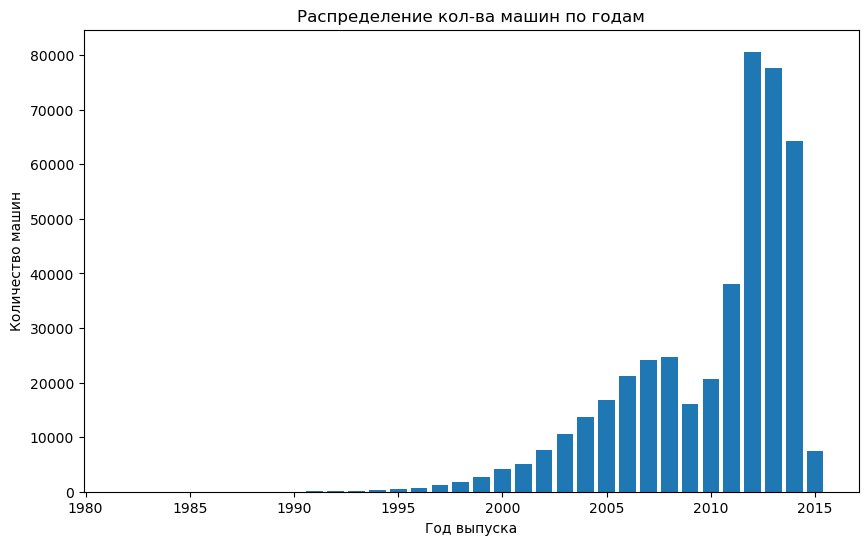

In [39]:
plt.figure(figsize =(10,6))
plt.bar(year_counts.index, year_counts.values)
plt.xlabel('Год выпуска')
plt.ylabel('Количество машин')
plt.title('Распределение кол-ва машин по годам')
plt.show()

Мы построили график распределения объема автомобилей по году их выпуска. Основная часть проданных автомобилей была произведена 2010-2014 годах. Построим график "яцик с усами" чтобы увидеть какого года выпуска был продан самый старый автомобиль и не является ли он выбросом

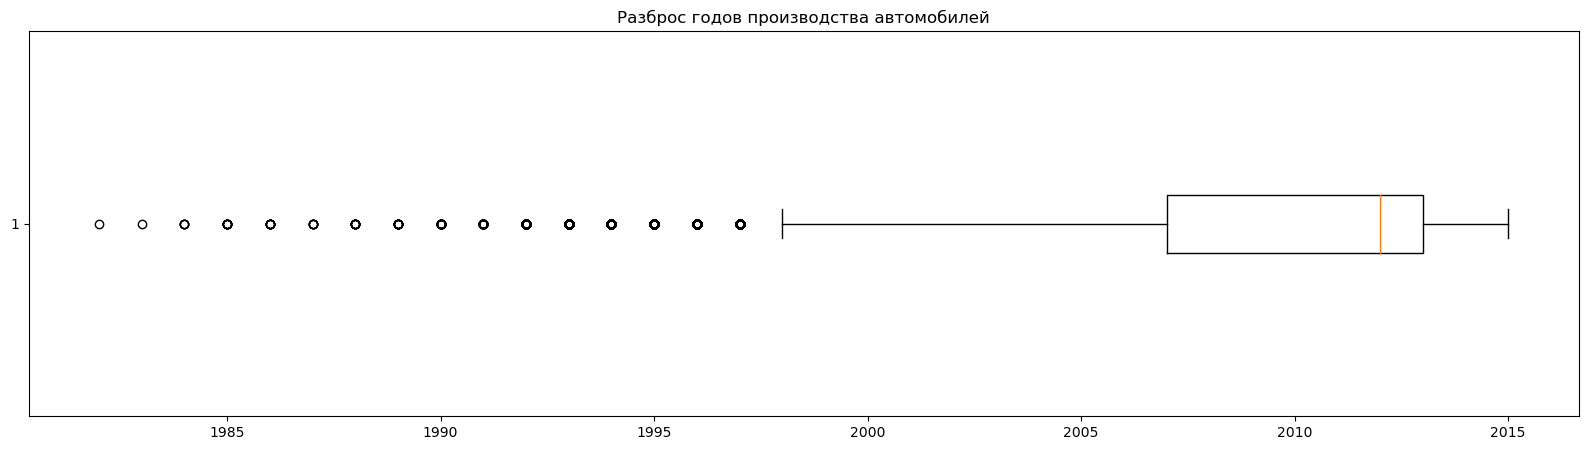

In [40]:
plt.figure(figsize=(20, 5))
plt.boxplot (data_train['year'], vert = False)
plt.title('Разброс годов производства автомобилей')
plt.show();

In [41]:
data_train['year'].value_counts()

2012    80625
2013    77566
2014    64225
2011    38115
2008    24646
2007    24152
2006    21118
2010    20647
2005    16794
2009    16064
2004    13658
2003    10512
2002     7726
2015     7462
2001     5147
2000     4161
1999     2658
1998     1747
1997     1224
1996      683
1995      567
1994      319
1993      168
1992      103
1991       56
1990       38
1989       15
1988       11
1985       10
1986        8
1987        5
1984        4
1983        1
1982        1
Name: year, dtype: int64

Мы видим, что основная часть автомобилей была выпущена 1998 - 2015 годы, продажа автомобилей выпущенных ранее являются единичными случаями, поэтому оставим в выборке только автомобили, произведенные в 1993 году и позднее, так как авто данного года выпуска превышает в количестве хотя бы 100 штук.

In [42]:
data_train = data_train[data_train['year'] >= 1993]

Посмотрим на данные по оценке состояния автомобиля на момент продажи. В описании ничего необычного замечено не было, но лучше все же увидеть наглядно.

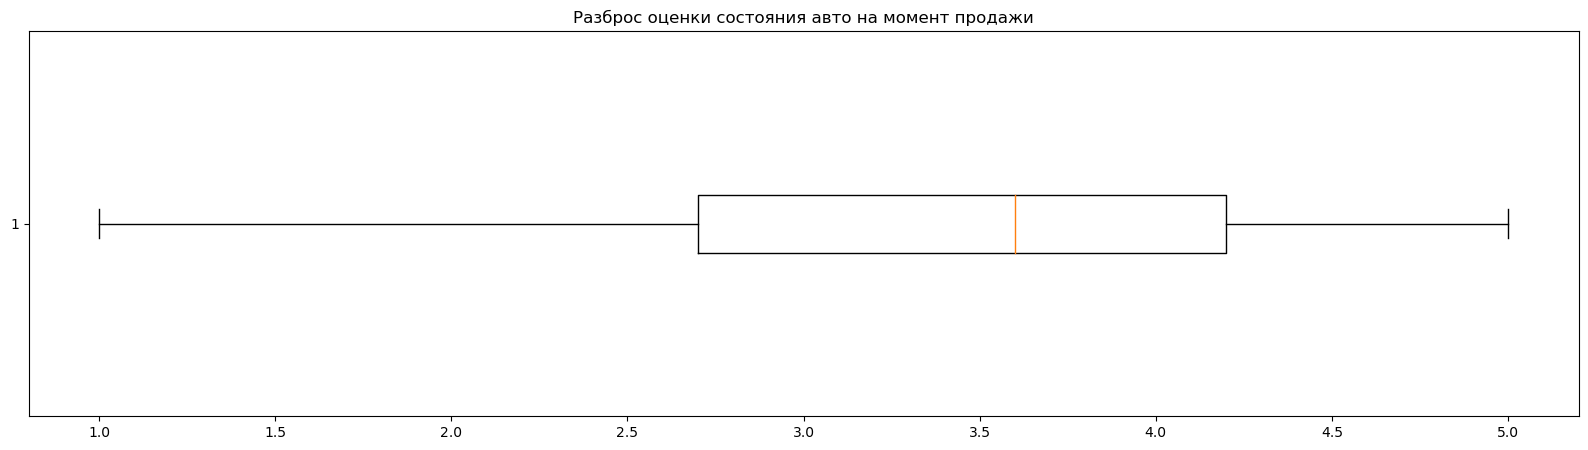

In [43]:
plt.figure(figsize=(20, 5))
plt.boxplot (data_train['condition'], vert = False)
plt.title('Разброс оценки состояния авто на момент продажи')
plt.show();

В оценках состояния авто действительно нет выбросов, все авто оценены от 1 до 5, бОльшая часть автомобилей имеет среднюю оценку. Теперь взглянем на показатели пробега автомобилей в данных.

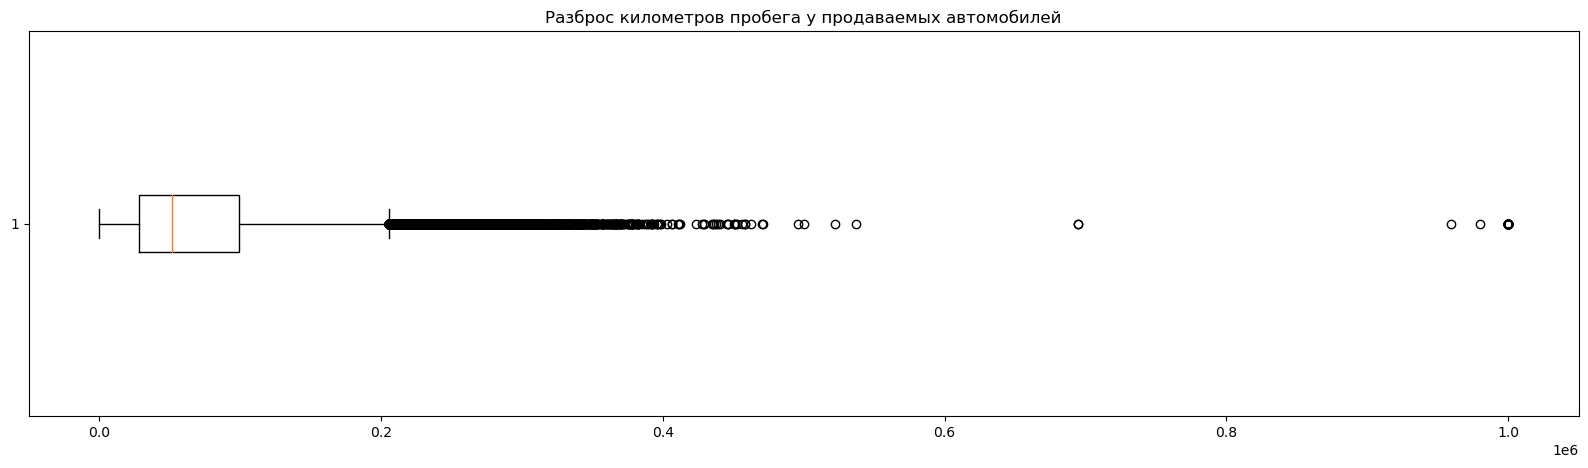

In [44]:
plt.figure(figsize=(20, 5))
plt.boxplot (data_train['odometer'], vert = False)
plt.title('Разброс километров пробега у продаваемых автомобилей')
plt.show();

Разброс действительно большой. Максимальный пробег составляет 999999. Посмотрим сколько автомобилей с таким пробегом в данных и какое значение будет следующим при сортировке по убыванию

In [45]:
data_train[data_train['odometer'] >= 999999]['odometer'].count()

55

In [46]:
data_train['odometer'].sort_values(ascending = False).iloc[50:60]

239758    999999.0
150893    999999.0
262840    999999.0
6069      999999.0
116247    999999.0
213734    980113.0
17341     959276.0
9830      694978.0
154833    694978.0
111232    537334.0
Name: odometer, dtype: float64

Также посмотрим минимальное значение и соседнее с ним в сортировке. Начнем с 10, хоть и в описании наших данных сказано, что минимальный пробег составляет 1. Даже если машина только вышла с конвеера и приехала в салон продажи значение в 1 км/м/милю кажется сомнительным

In [47]:
data_train[data_train['odometer'] <= 10]['odometer'].count()

1154

In [48]:
data_train['odometer'].sort_values(ascending = True).iloc[1010:1100]

394275    1.0
16922     1.0
275392    1.0
45056     1.0
425423    1.0
         ... 
74430     6.0
129931    6.0
357323    6.0
127481    7.0
696       7.0
Name: odometer, Length: 90, dtype: float64

Оставим данные о тех автомобилях, которые имеют пробег более 10 единиц и менее 959276

In [49]:
data_train = data_train[(data_train['odometer'] >= 10) & (data_train['odometer'] <= 959276)]

Изучим разброс цен, за которые были проданы автомобили.

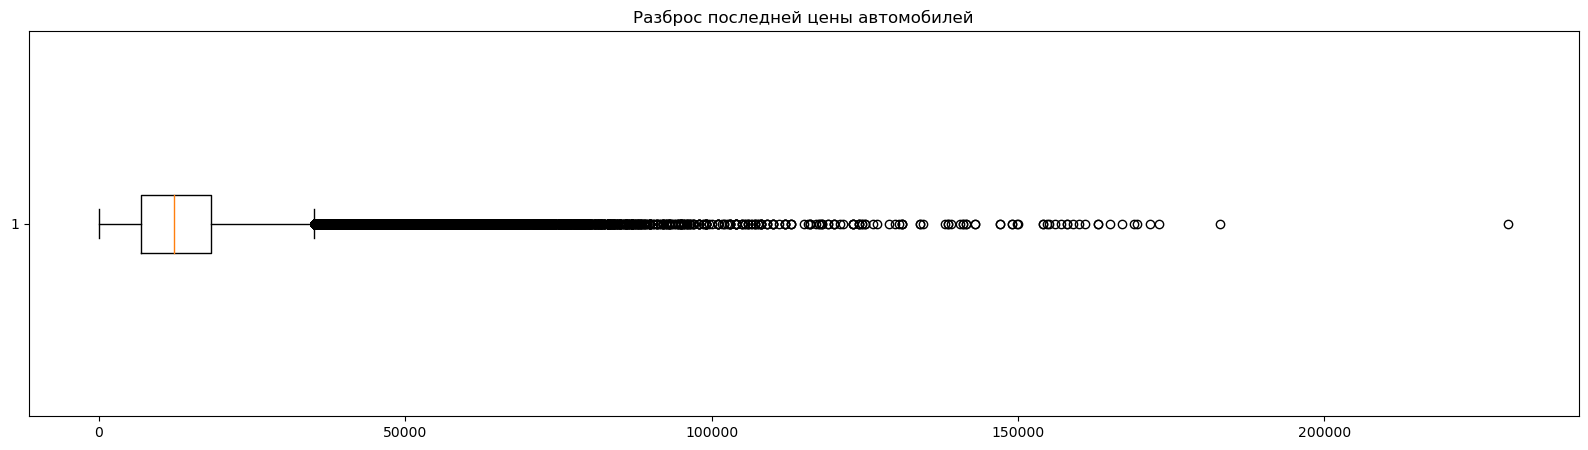

In [50]:
plt.figure(figsize=(20, 5))
plt.boxplot (data_train['sellingprice'], vert = False)
plt.title('Разброс последней цены автомобилей')
plt.show();

Начнем с минимальной цены. Посмотрим сколько автомобилей было продано за 1 у.е. и какое следующее значение при сортировке по возрастанию.

In [51]:
data_train[data_train['sellingprice'] <= 1]['odometer'].count()

1

In [52]:
data_train['sellingprice'].sort_values(ascending = True).iloc[:30]

418021      1
227267    100
413415    100
90212     100
262011    100
368828    100
51885     100
51979     100
292850    100
317945    100
346972    100
18762     100
189460    100
331771    100
355906    100
414775    125
422347    150
323401    150
306434    150
16457     150
90262     150
223098    150
147052    150
90128     150
302626    150
432667    150
131324    150
14811     150
301820    150
32013     175
Name: sellingprice, dtype: int64

In [53]:
data_train['sellingprice'].sort_values(ascending = False)#.iloc[:30]

392004    230000
423302    183000
359111    173000
26083     171500
291685    169500
           ...  
90212        100
413415       100
346972       100
227267       100
418021         1
Name: sellingprice, Length: 438797, dtype: int64

In [54]:
data_train[data_train['sellingprice'] >= 140000]['odometer'].count()

34

Автомобиль проданный за 1 у.е. всего один, а вот автомобилей проданных более чем за 140 000 более 30. Высокая цена выбивается из основной части. Поэтому удаляем из данных машины дороже 140 000 и автомобиль проданный за 1.

In [55]:
data_train = data_train[(data_train['sellingprice'] <= 140000) & (data_train['sellingprice'] > 1)]

Мы убрали из выборки выбросы и некорректные значения. Проверим сколько из общего объема данных мы убрали и не является ли этот объем критичным.

In [56]:
data_train.shape

(438762, 15)

Изначально в тренировочной выборке было 440236 строк. При обработке мы лишились 1474 строк, что менее 1% и это более чем допустимо. Приступим к добавлению новых,синтетических данных, которые помогут нашей модели лучше увидеть закономерности и давать наиболее точные прогнозы. Для этого еще раз взглянем на наши данные

In [57]:
data_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,tue jun 02 2015 02:30:00 gmt-0700 (pdt)
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,wed feb 25 2015 02:00:00 gmt-0800 (pst)
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,wed jun 10 2015 02:30:00 gmt-0700 (pdt)
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,wed jun 17 2015 03:00:00 gmt-0700 (pdt)
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,tue feb 03 2015 04:00:00 gmt-0800 (pst)


Мы видим, что год поизводства автомобиля и дата продажи автомобиля имеют неверный формат данных. Приведем их к верному формату и создадим новый столбец с количсетвом дней от момента производства автомобиля до момента его продажи на вторичном рынке.

In [58]:
data_train ['year_datetime'] = pd.to_datetime(data_train['year'], format = '%Y').dt.strftime('%d.%m.%Y')
data_train ['year_datetime'] = pd.to_datetime(data_train ['year_datetime'], format = ('%d.%m.%Y'))

In [59]:
data_test ['year_datetime'] = pd.to_datetime(data_test['year'], format = '%Y').dt.strftime('%d.%m.%Y')
data_test ['year_datetime'] = pd.to_datetime(data_test ['year_datetime'], format = ('%d.%m.%Y'))

In [60]:
# Используем регулярное выражение для извлечения даты в столбце с датой продажи автомобиля.
date_pattern = r'(\w{3} \w{3} \d{2} \d{4} \d{2}:\d{2}:\d{2})'
data_train['saledate_datetime'] = data_train['saledate'].str.extract(date_pattern, expand=False)
data_train['saledate_datetime'] = pd.to_datetime(data_train['saledate_datetime'], format='%a %b %d %Y %H:%M:%S').dt.strftime('%d.%m.%Y')
data_train['saledate_datetime'] = pd.to_datetime(data_train['saledate_datetime'], format = ('%d.%m.%Y'))

In [61]:
# Аналогично делаем и для тестовой выборки
date_pattern = r'(\w{3} \w{3} \d{2} \d{4} \d{2}:\d{2}:\d{2})'
data_test['saledate_datetime'] = data_test['saledate'].str.extract(date_pattern, expand=False)
data_test['saledate_datetime'] = pd.to_datetime(data_test['saledate_datetime'], format='%a %b %d %Y %H:%M:%S').dt.strftime('%d.%m.%Y')
data_test['saledate_datetime'] = pd.to_datetime(data_test['saledate_datetime'], format = ('%d.%m.%Y'))

In [62]:
# Создаем новый столбец с данными и приводим его в числовой формат
data_train['expluatacion_days'] = (data_train['saledate_datetime'] - data_train['year_datetime']).dt.days
data_test['expluatacion_days'] = (data_test['saledate_datetime'] - data_test['year_datetime']).dt.days

Создаем еще один столбец с синтетическими данными: сколько в среднем проезжал автомобиль за день. Для этого делим пробег на количество дней жизни автомобиля.

In [63]:
data_train['mileage_per_day'] = (data_train['odometer']/data_train['expluatacion_days']).round(2)
data_test['mileage_per_day'] = (data_test['odometer']/data_train['expluatacion_days']).round(2)
data_test['mileage_per_day'] = data_test['mileage_per_day'] .fillna(data_test['mileage_per_day'].median())

Проверим не появилось ли при делении значений равных бесконечности.

In [64]:
data_train[data_train.isin([np.inf, -np.inf]).any(axis = 1)]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,year_datetime,saledate_datetime,expluatacion_days,mileage_per_day
2180,2014,toyota,camry,xle,sedan,automatic,4t1bf1fk3eu327266,sc,3.0,33959.0,gray,gray,enterprise vehicle exchange / tra / rental / t...,14800,wed jan 01 2014 09:15:00 gmt-0800 (pst),2014-01-01,2014-01-01,0,inf
11022,2014,chevrolet,malibu,lt,sedan,automatic,1g11e5sl4ef137451,sc,2.7,27495.0,black,black,enterprise veh exchange/rental,13800,wed jan 01 2014 09:15:00 gmt-0800 (pst),2014-01-01,2014-01-01,0,inf
38837,2014,ford,f-250 super duty,xl,crew cab,automatic,1ft7w2b66eea10763,sc,4.2,19808.0,white,gray,enterprise veh exchange/rental,26500,wed jan 01 2014 09:15:00 gmt-0800 (pst),2014-01-01,2014-01-01,0,inf
49792,2014,chrysler,town and country,touring,minivan,automatic,2c4rc1bg9er131861,sc,2.0,28905.0,white,tan,enterprise vehicle exchange / tra / rental / t...,13600,wed jan 01 2014 11:00:00 gmt-0800 (pst),2014-01-01,2014-01-01,0,inf
97329,2014,dodge,challenger,sxt,coupe,automatic,2c3cdyagxeh224606,sc,2.0,25586.0,silver,black,enterprise vehicle exchange / tra / rental / t...,15900,wed jan 01 2014 11:00:00 gmt-0800 (pst),2014-01-01,2014-01-01,0,inf
254760,2015,chevrolet,suburban,lt,suv,automatic,1gnscjkcxfr165840,sc,1.0,6914.0,black,gray,enterprise vehicle exchange / tra / rental / t...,37200,thu jan 01 2015 11:00:00 gmt-0800 (pst),2015-01-01,2015-01-01,0,inf
352181,2014,chrysler,200,lx,sedan,automatic,1c3ccbab5en141595,sc,2.0,28176.0,burgundy,silver,enterprise vehicle exchange / tra / rental / t...,9700,wed jan 01 2014 11:00:00 gmt-0800 (pst),2014-01-01,2014-01-01,0,inf
409159,2015,mazda,cx-5,touring,suv,automatic,jm3ke2cy0f0435575,sc,1.0,19276.0,silver,black,enterprise vehicle exchange / tra / rental / t...,11600,thu jan 01 2015 11:00:00 gmt-0800 (pst),2015-01-01,2015-01-01,0,inf
436660,2014,chevrolet,captiva sport,ltz fleet,suv,automatic,3gnal4ek8es560059,sc,2.8,34169.0,black,gray,enterprise veh exchange/rental,15000,wed jan 01 2014 09:15:00 gmt-0800 (pst),2014-01-01,2014-01-01,0,inf


In [65]:
data_test[data_test.isin([np.inf, -np.inf]).any(axis = 1)]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,year_datetime,saledate_datetime,expluatacion_days,mileage_per_day
2180,2007,chevrolet,equinox,ls,suv,automatic,2cndl23f376004559,nc,2.9,97725.0,black,gray,manheim statesville,tue jan 20 2015 01:30:00 gmt-0800 (pst),2007-01-01,2015-01-20,2941,inf
11022,2014,ford,explorer,sport,suv,automatic,1fm5k8gt3egc39955,mo,4.2,20814.0,off-white,black,kc landsmen ars,wed jan 21 2015 02:00:00 gmt-0800 (pst),2014-01-01,2015-01-21,385,inf
38837,2007,ford,f-150,fx4,supercrew,automatic,1ftpw14v67kc80708,tx,2.0,184613.0,white,black,allen samuels chrysler dodge jeep ram,wed feb 18 2015 02:00:00 gmt-0800 (pst),2007-01-01,2015-02-18,2970,inf
49792,2014,kia,sportage,lx,suv,automatic,kndpb3ac3e7563075,nv,3.7,16923.0,black,gray,"kia motors america, inc",fri feb 06 2015 04:00:00 gmt-0800 (pst),2014-01-01,2015-02-06,401,inf
97329,2014,nissan,altima,2.5 s,sedan,automatic,1n4al3ap6en351293,fl,3.5,31215.0,silver,black,avis corporation,tue may 26 2015 02:15:00 gmt-0700 (pdt),2014-01-01,2015-05-26,510,inf


Так как бесконечные значения все же были обнаружены в обоих датасетах, хоть и не в большом количестве, заменим их значения медианным значением.

In [66]:
train_index = data_train[data_train.isin([np.inf, -np.inf]).any(axis = 1)].index
test_index = data_test[data_test.isin([np.inf, -np.inf]).any(axis = 1)].index
data_train.loc[train_index,'mileage_per_day'] = data_train['mileage_per_day'].median()
data_test.loc[test_index,'mileage_per_day'] = data_test['mileage_per_day'].median()

Построим матрицу корреляции чтоб посмотреть имеются ли сильные зависимости между нашими параметрами и решим что можно и нужно ли с ними сделать, так как в будущем это может повлиять на результаты нашего обучения

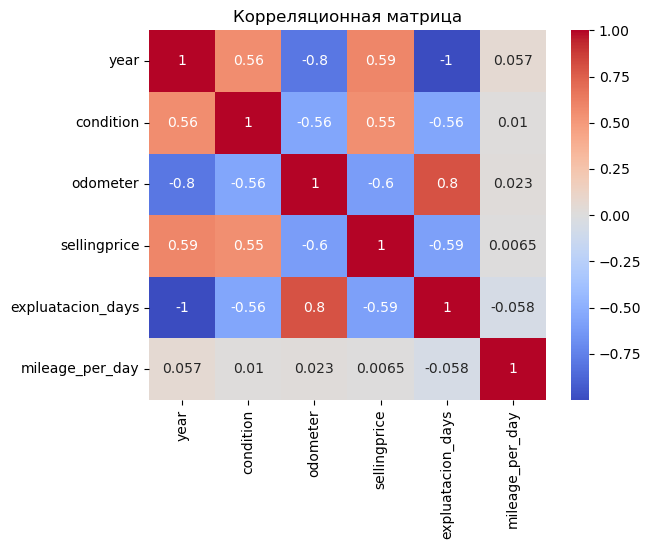

In [67]:
sns.heatmap(data_train.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

Год производства и пробег и год производства и дни жизни автомобиля имеют высокую обратную зависимоть. Также как и пробег и дни жизни имеют высокую прямую зависимость. Вероятно, стоило бы удалить некоторые столбцы, но так как я не планирую использовать линейные модели и считаю эти признаки достаточно значимыми,то оставлю их.

## 2. Обучение моделей

Перед тем как приступить к обучению моделей удалим из выборок столбцы, которые не несут в себе никакой значимой информации и никак не помогут обучению нашей модели.

In [68]:
data_train = data_train.drop(columns = ['vin', 'seller', 'saledate', 'year_datetime', 'saledate_datetime'])
data_test = data_test.drop(columns = ['vin', 'seller', 'saledate', 'year_datetime', 'saledate_datetime'])

Теперь разделим нашу выборку на признаки для обучения и целевой признак (цена продажи). Так как тестовая выборка не имеет целевого признака и на ней мы будем делать предсказания на лучшей модели, то просто немного скорректируем название ее переменной для дальнейшего удобства.

In [69]:
features_train = data_train.drop(columns = 'sellingprice')
target_train = data_train['sellingprice']

features_test = data_test

Для некоторых моделей необходимо кодирование не числовых признаков. Заранее выделим имена столбцов с такими признаками для последующего удобства использования.

In [70]:
oe_features = features_train.drop(columns = ['year', 'condition', 'odometer', 'expluatacion_days', 'mileage_per_day']).columns

Закодируем необходимые признаки посредством LabelEncoder. Датасет с незакодированными признаки сохраним в отдельной переменной.

In [71]:
not_encod_features_train = features_train.copy()
label_encoder = LabelEncoder()
for column in oe_features.tolist():
    features_train[column] = label_encoder.fit_transform(features_train[column])

Нашей первой обученной моделью будет модель случайного леса. Подбор оптимальных параметров будет производиться посредством Optuna.Создаем модель, которая будет перебирать параметры и искать оптимальные, задаем сами параметры и начинаем обучение.

In [72]:
def objective(trial):
    # Параметры для оптимизации
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 16)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)

    # Создание и обучение модели с выбранными параметрами
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Оценка модели с помощью кросс-валидации и метрики MAPE на тренировочных данных
    target_train_pred = cross_val_predict(model, features_train, target_train, cv=3)
    mape = mean_absolute_percentage_error(target_train, target_train_pred) * 100

    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Получение наилучших параметров
best_params_rf = study.best_trial.params

# Создание и обучение лучшей модели
best_model_rf = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    random_state=327
)
best_model_rf.fit(features_train, target_train)

# Оценка качества модели на тренировочных данных
target_train_pred = best_model_rf.predict(features_train)
mape = mean_absolute_percentage_error(target_train, target_train_pred)

[I 2023-09-02 20:05:26,217] A new study created in memory with name: no-name-37c36f8a-a369-4cfd-a696-d86622bc960b
[I 2023-09-02 20:05:58,551] Trial 0 finished with value: 98.09003047124143 and parameters: {'n_estimators': 74, 'max_depth': 10, 'min_samples_split': 0.5195252653929443, 'min_samples_leaf': 0.18252024592177607}. Best is trial 0 with value: 98.09003047124143.
[I 2023-09-02 20:06:03,214] Trial 1 finished with value: 176.32467131067355 and parameters: {'n_estimators': 84, 'max_depth': 2, 'min_samples_split': 0.5042912921076894, 'min_samples_leaf': 0.4336983000847038}. Best is trial 0 with value: 98.09003047124143.
[I 2023-09-02 20:06:04,870] Trial 2 finished with value: 176.29613673718575 and parameters: {'n_estimators': 27, 'max_depth': 15, 'min_samples_split': 0.4911872714456287, 'min_samples_leaf': 0.48507975916754487}. Best is trial 0 with value: 98.09003047124143.
[I 2023-09-02 20:06:08,981] Trial 3 finished with value: 176.3321485260191 and parameters: {'n_estimators': 7

Выводим на экран лучший показатель метрики и параметры при котором он был получен.

In [73]:
print('Параметры лучшей модели:', best_params_rf)
print('Лучший показатель метрики МАРЕ:',study.best_trial.value)

Параметры лучшей модели: {'n_estimators': 69, 'max_depth': 6, 'min_samples_split': 0.150166132345488, 'min_samples_leaf': 0.10470396754789107}
Лучший показатель метрики МАРЕ: 70.16553497433058


Второй нашей моделью будет LihgtGBM. Также создаем функцию, задаем параметры и запускаем обучение.

In [74]:
def objective(trial):
    # Параметры для оптимизации
    params = {
        'objective': 'regression',
        'metric': 'mape',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'random_state': 327
    }

    # Создание и обучение модели с выбранными параметрами
    model = lgb.LGBMRegressor(**params)

    # Оценка модели с помощью кросс-валидации и метрики MAPE
    target_train_pred = cross_val_predict(model, features_train, target_train, cv=3)
    mape = np.mean(np.abs((target_train - target_train_pred) / target_train)) * 100

    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Получение наилучших параметров
best_params_lgb = study.best_trial.params

# Создание и обучение лучшей модели
best_model_lgb = lgb.LGBMRegressor(**best_params_lgb)
best_model_lgb.fit(features_train, target_train)

[I 2023-09-02 20:35:45,462] A new study created in memory with name: no-name-bd8ff728-f299-4eff-9f0c-36741996fbce
[I 2023-09-02 20:35:49,742] Trial 0 finished with value: 36.80636069303957 and parameters: {'n_estimators': 71, 'learning_rate': 0.12924382807419518, 'max_depth': 3, 'colsample_bytree': 0.5453473736782485, 'subsample': 0.9434226598070349}. Best is trial 0 with value: 36.80636069303957.
[I 2023-09-02 20:35:53,278] Trial 1 finished with value: 117.86234570735647 and parameters: {'n_estimators': 64, 'learning_rate': 0.01124263989314854, 'max_depth': 2, 'colsample_bytree': 0.6941175367699632, 'subsample': 0.4015628965066881}. Best is trial 0 with value: 36.80636069303957.
[I 2023-09-02 20:36:00,558] Trial 2 finished with value: 67.27528407531275 and parameters: {'n_estimators': 80, 'learning_rate': 0.02006961475031396, 'max_depth': 15, 'colsample_bytree': 0.9504147108903717, 'subsample': 0.16304064695728998}. Best is trial 0 with value: 36.80636069303957.
[I 2023-09-02 20:36:07

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1522
[LightGBM] [Info] Number of data points in the train set: 438762, number of used features: 13
[LightGBM] [Info] Start training from score 13615.028391


LGBMRegressor(colsample_bytree=0.7713671646048853,
              learning_rate=0.29792923331524507, max_depth=12, n_estimators=98,
              subsample=0.6478051636778427)

Выводим на экран лучшие результаты.

In [75]:
print('Параметры лучшей моедли:', best_params_lgb)
print('Лучший показатель метрики МАРЕ:',study.best_trial.value)

Параметры лучшей моедли: {'n_estimators': 98, 'learning_rate': 0.29792923331524507, 'max_depth': 12, 'colsample_bytree': 0.7713671646048853, 'subsample': 0.6478051636778427}
Лучший показатель метрики МАРЕ: 21.14410623343759


Вторая модель справилась с обучением значительно лучше. Обучим третью модель CatBoost. Эта модель работает и с не закодированными данными, поэтому передаем ей обучающие признаки в начальном формате.

In [76]:
def objective(trial):
    # Параметры для оптимизации
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 16)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.1, 1.0)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)

    # Создание и обучение модели с выбранными параметрами
    model = CatBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        colsample_bylevel=colsample_bylevel,
        subsample=subsample,
        random_seed=327,
        verbose=False,
        cat_features=oe_features.tolist()
    )

    # Оценка модели с помощью кросс-валидации и метрики MAPE
    target_train_pred = cross_val_predict(model, not_encod_features_train, target_train, cv=3)
    mape = np.mean(np.abs((target_train - target_train_pred) / target_train)) * 100

    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Получение наилучших параметров
best_params_cb = study.best_trial.params

# Создание и обучение лучшей модели
best_model_cb = CatBoostRegressor(
    n_estimators=best_params_cb['n_estimators'],
    learning_rate=best_params_cb['learning_rate'],
    max_depth=best_params_cb['max_depth'],
    colsample_bylevel=best_params_cb['colsample_bylevel'],
    subsample=best_params_cb['subsample'],
    random_seed=42,
    verbose=False
)
best_model_cb.fit(not_encod_features_train, target_train, cat_features=oe_features.tolist())

[I 2023-09-02 20:45:32,648] A new study created in memory with name: no-name-d5b74180-9f9d-4373-89a6-6e5eaf96d88a


[I 2023-09-02 20:45:48,020] Trial 0 finished with value: 115.40885971196688 and parameters: {'n_estimators': 17, 'learning_rate': 0.03443751926981387, 'max_depth': 7, 'colsample_bylevel': 0.3120348343089851, 'subsample': 0.4297809919032941}. Best is trial 0 with value: 115.40885971196688.
[I 2023-09-02 20:46:02,591] Trial 1 finished with value: 51.00368864463789 and parameters: {'n_estimators': 15, 'learning_rate': 0.13794602298441894, 'max_depth': 8, 'colsample_bylevel': 0.38622153190343755, 'subsample': 0.9629420681856768}. Best is trial 1 with value: 51.00368864463789.
[I 2023-09-02 20:46:16,632] Trial 2 finished with value: 146.31025742408033 and parameters: {'n_estimators': 18, 'learning_rate': 0.013631056880691024, 'max_depth': 7, 'colsample_bylevel': 0.4411627840975092, 'subsample': 0.6589662301834771}. Best is trial 1 with value: 51.00368864463789.
[I 2023-09-02 20:46:32,980] Trial 3 finished with value: 117.91256634744404 and parameters: {'n_estimators': 60, 'learning_rate': 0

Выводим лучшие параметры модели и метрику, полученную при обучении на тренировочной выборке.

In [77]:
print('Параметры лучшей моедли:', best_params_cb)
print('Лучший показатель метрики МАРЕ:',study.best_trial.value)

Параметры лучшей моедли: {'n_estimators': 100, 'learning_rate': 0.19377210672493927, 'max_depth': 16, 'colsample_bylevel': 0.7440361250896925, 'subsample': 0.7088450064194369}
Лучший показатель метрики МАРЕ: 16.920890089907072


Обучив три модели мы получили следующие результаты MAPE:<br>
- RandomForest 70.17<br>
- LightGBM 21.14<br>
- CatBoost 16.92<br>
В нашем случае лучше всего обучилась модель CatBoost. Посмотрим какие признаки имели наибольшую и наименьшую роль в обучении модели.

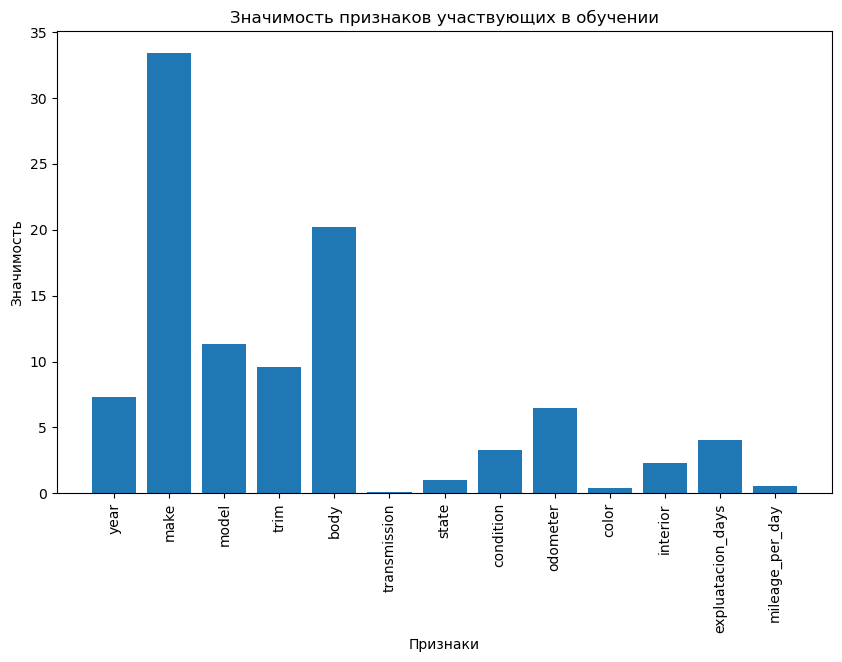

In [78]:
feature_importance = best_model_cb.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xticks(range(len(feature_importance)), features_train.columns.tolist(), rotation='vertical')
plt.xlabel('Признаки')
plt.ylabel('Значимость')
plt.title('Значимость признаков участвующих в обучении')
plt.show()

Наименьшее значение в обучении модели имеют параметры цвета автомобиля и трансмиссия. Уберем эти параметры из данных и еще раз проведем обучение  лучшей модели, посмотрим изменится ли метрика

In [79]:
not_encod_features_train = not_encod_features_train.drop(columns = ['transmission', 'color'])
oe_features = oe_features.drop('color')
oe_features = oe_features.drop('transmission')

In [83]:
def objective(trial):
    # Параметры для оптимизации
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 16)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.1, 1.0)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)

    # Создание и обучение модели с выбранными параметрами
    model = CatBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        colsample_bylevel=colsample_bylevel,
        subsample=subsample,
        random_seed=327,
        verbose=False,
        cat_features=oe_features.tolist()
    )

    # Оценка модели с помощью кросс-валидации и метрики MAPE
    target_train_pred = cross_val_predict(model, not_encod_features_train, target_train, cv=3)
    mape = np.mean(np.abs((target_train - target_train_pred) / target_train)) * 100

    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Получение наилучших параметров
best_params_cb_two= study.best_trial.params

# Создание и обучение лучшей модели
best_model_cb_two = CatBoostRegressor(
    n_estimators=best_params_cb_two['n_estimators'],
    learning_rate=best_params_cb_two['learning_rate'],
    max_depth=best_params_cb_two['max_depth'],
    colsample_bylevel=best_params_cb_two['colsample_bylevel'],
    subsample=best_params_cb_two['subsample'],
    random_seed=42,
    verbose=False
)
best_model_cb_two.fit(not_encod_features_train, target_train, cat_features=oe_features.tolist())

[I 2023-09-02 22:01:38,843] A new study created in memory with name: no-name-2a9675a0-895e-4e18-90d6-ba7625a25517
[I 2023-09-02 22:01:54,572] Trial 0 finished with value: 64.6691945270396 and parameters: {'n_estimators': 19, 'learning_rate': 0.07402178300154524, 'max_depth': 13, 'colsample_bylevel': 0.45369946322689303, 'subsample': 0.21915514064533492}. Best is trial 0 with value: 64.6691945270396.
[I 2023-09-02 22:02:03,976] Trial 1 finished with value: 51.62267525726525 and parameters: {'n_estimators': 69, 'learning_rate': 0.07186769889580912, 'max_depth': 11, 'colsample_bylevel': 0.10301324552249849, 'subsample': 0.7175804714497925}. Best is trial 1 with value: 51.62267525726525.
[I 2023-09-02 22:03:31,418] Trial 2 finished with value: 53.115648619790804 and parameters: {'n_estimators': 84, 'learning_rate': 0.02280149608977241, 'max_depth': 15, 'colsample_bylevel': 0.2564808359563602, 'subsample': 0.5582267500360613}. Best is trial 1 with value: 51.62267525726525.
[I 2023-09-02 22:

In [84]:
print('Параметры лучшей моедли:', best_model_cb_two)
print('Лучший показатель метрики МАРЕ:',study.best_trial.value)

Параметры лучшей моедли: <catboost.core.CatBoostRegressor object at 0x000001B6B593B9D0>
Лучший показатель метрики МАРЕ: 20.828225943768604


Показатели метрики модели, обученной без признаков оказывающих минимально влияние на обучение, оказались хуже начальной. Поэтому для предсказания для тестовых данных мы будем использовать изначальный вариант модели CatBoost с параметрами цвета автомобиля и трансмиссии.

In [85]:
test_prediction = best_model_cb.predict(features_test)

Сохраняем полученные результаты для дальнейшей загрузки на платформу Kaggle.

In [92]:
test_prediction_df = pd.DataFrame({'saleprice':test_prediction})

In [94]:
test_prediction_df.to_csv('predicted_values.csv', index=False)

## Подведение итогов

В результате нашей работы мы корректно выгрузили данные, смогли заполниить пропуски, скорректировать определенные ппараметры и убрать выбросы из данных используя различные инструменты для аналища и обработки данных. Также мы смогли обучить три модели: RandomForest, LightGBM и CatBoost, подобрав оптимальные параметры для оптимальной метрики качества обучения MAPE посретдством Optuna. Лучший результат дала модель CatBoost с метрикой равной 16.92. Далее было проведено исследование значимости признаков для обучения и выявлено два признака "color" и "transmission" которые оказывали минимальное влияние на качество обучение модели. Убрав эти признаки из набора данных мы еще раз обучили лучшую модель, но показатели метрики оказались хуже, чем при наличие признаков описанных ранее. Поэтому, было принято решение, что для предсказания цен автомобилей на вторичном рынке из тестового набора данных будет использоваться изначальная модель CatBoost.Получив предсказания мы сохранили их в отдельный файл.